# MV of S&P 500

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
filepath_data = '../data/spx_returns_weekly.xlsx'
SHEET = 's&p500 rets'
rets_raw = pd.read_excel(filepath_data,sheet_name=SHEET).set_index('date')

In [ ]:
def delta_parameter(target_mean):
    delta = (target_mean - mu.T@w_gmv)/(mu.T@w_tan - mu.T@w_gmv)
    return delta

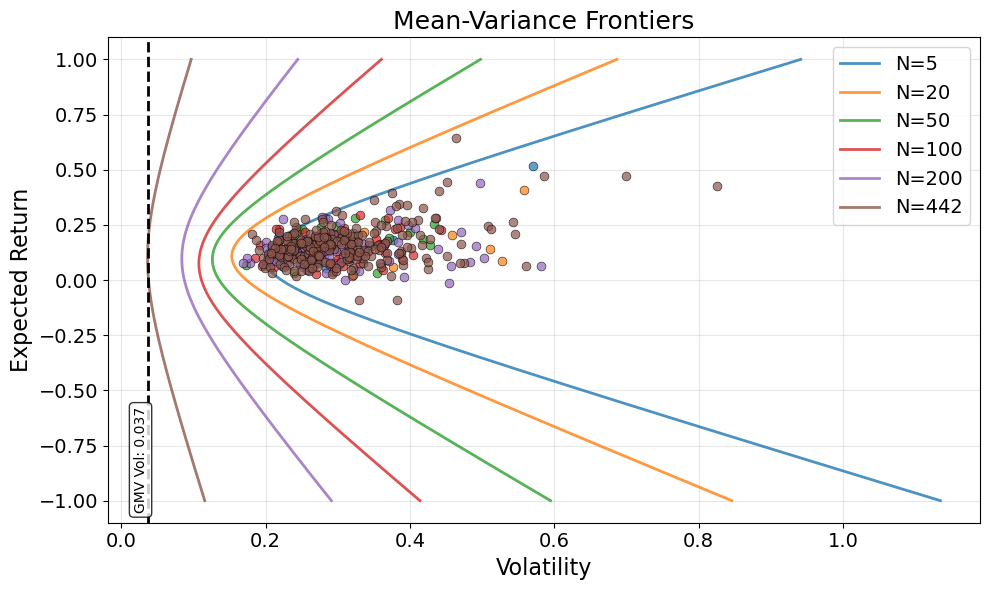

In [ ]:
# Multi-Frontier Plot for Various N Values (Nested Subsamples)
N_values = [5, 20, 50, 100, 200, len(rets_raw.columns)]

fig, ax = plt.subplots(figsize=(10, 6))

# Create nested subsamples
np.random.seed(2025)  # Use same seed for reproducibility
all_assets = list(rets_raw.columns)
np.random.shuffle(all_assets)  # Shuffle once for consistent ordering

# Track which assets are included at each N level
asset_inclusion_level = {}
nested_asset_sets = {}

# Initialize summary data storage
summary_data = []

# Create nested sets
for i, N in enumerate(N_values):
    if N > len(rets_raw.columns):
        continue  # Skip if N is larger than available assets
    
    # For the first N, take the first N assets
    # For subsequent N values, take the previous assets plus additional ones
    if i == 0:
        selected_assets = all_assets[:N]
    else:
        # Take all assets from previous levels plus additional ones
        selected_assets = nested_asset_sets[N_values[i-1]] + all_assets[len(nested_asset_sets[N_values[i-1]]):N]
    
    nested_asset_sets[N] = selected_assets
    idx = sorted(selected_assets)
    rets_n = rets_raw[idx]
    
    # Track which N level each asset was first included in
    for asset in selected_assets:
        if asset not in asset_inclusion_level:
            asset_inclusion_level[asset] = N
    
    # Calculate metrics for this N
    mu_n = rets_n.mean() * FREQ
    covmat_n = rets_n.cov() * FREQ
    vec_ones_n = np.ones(mu_n.shape)
    
    # Calculate GMV and tangency portfolios
    w_gmv_n = np.linalg.solve(covmat_n, vec_ones_n)
    w_tan_n = np.linalg.solve(covmat_n, mu_n)
    w_gmv_n /= w_gmv_n.sum()
    w_tan_n /= w_tan_n.sum()
    
    # Calculate Sharpe ratios and gross market value for this N
    # Individual asset Sharpe ratios
    individual_sharpe = mu_n / (rets_n.std() * np.sqrt(FREQ))
    max_individual_sharpe = individual_sharpe.max()
    
    # Tangency portfolio Sharpe ratio
    tangency_sharpe = (mu_n.T @ w_tan_n) / np.sqrt(w_tan_n.T @ covmat_n @ w_tan_n)
    
    # Gross market value of tangency portfolio
    gross_market_value = np.abs(w_tan_n).sum()
    
    # Store summary data
    summary_data.append({
        'N': N,
        'Max_Individual_Sharpe': max_individual_sharpe,
        'Tangency_Sharpe': tangency_sharpe,
        'Gross_Market_Value': gross_market_value
    })
    
    # Define delta parameter function for this N
    def delta_parameter_n(target_mean):
        delta = (target_mean - mu_n.T@w_gmv_n)/(mu_n.T@w_tan_n - mu_n.T@w_gmv_n)
        return delta
    
    # Create frontier for this N
    MAX_n = (N+5) * .0005 * FREQ
    MIN_n = - MAX_n/1.6
    MAX_n = -1
    MIN_n = 1
    
    grid_n = np.linspace(MIN_n, MAX_n, 250)
    df_n = pd.DataFrame(index=grid_n, columns=['delta','mu','vol'], dtype=float)
    
    for mu_target in grid_n:
        delta = delta_parameter_n(mu_target)
        w = delta * w_tan_n + (1-delta) * w_gmv_n
        df_n.loc[mu_target,'delta'] = delta
        df_n.loc[mu_target,'mu'] = w.T @ mu_n
        df_n.loc[mu_target,'vol'] = np.sqrt(w.T @ covmat_n @ w)
    
    # Plot this frontier
    ax.plot(df_n['vol'], df_n['mu'], 
            linewidth=2, alpha=0.8, label=f'N={N}')

# Plot base assets colored by inclusion level
base_mu = rets_raw.mean() * FREQ
base_vol = rets_raw.std() * np.sqrt(FREQ)

# Create color mapping for assets based on their first inclusion level
for N in N_values:
    if N > len(rets_raw.columns):
        continue
    
    # Get assets that were first included at this N level
    assets_at_level = [asset for asset, level in asset_inclusion_level.items() if level == N]
    
    if assets_at_level:
        # Get the corresponding mu and vol for these assets
        mu_at_level = base_mu[assets_at_level]
        vol_at_level = base_vol[assets_at_level]
        
        # Plot with the color corresponding to this N level
        color_idx = N_values.index(N)
        ax.scatter(vol_at_level, mu_at_level, 
                  alpha=0.7, s=40, 
                  zorder=5, edgecolors='black', linewidth=0.5)

# Add vertical line at the global minimum variance portfolio of the largest N
largest_N = N_values[-1]
if largest_N <= len(rets_raw.columns):
    # Get the assets for the largest N
    largest_assets = nested_asset_sets[largest_N]
    largest_rets = rets_raw[largest_assets]
    
    # Calculate GMV portfolio for largest N
    largest_mu = largest_rets.mean() * FREQ
    largest_covmat = largest_rets.cov() * FREQ
    largest_vec_ones = np.ones(largest_mu.shape)
    largest_w_gmv = np.linalg.solve(largest_covmat, largest_vec_ones)
    largest_w_gmv /= largest_w_gmv.sum()
    
    # Calculate volatility of GMV portfolio
    gmv_vol = np.sqrt(largest_w_gmv.T @ largest_covmat @ largest_w_gmv)
    
    # Add vertical line
    ax.axvline(x=gmv_vol, color='black', linestyle='--', linewidth=2)
    
    # Add text label on x-axis
    ax.text(gmv_vol, ax.get_ylim()[0] + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 
            f'GMV Vol: {gmv_vol:.3f}', 
            rotation=90, verticalalignment='bottom', horizontalalignment='right',
            fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Volatility', fontsize=16)
ax.set_ylabel('Expected Return', fontsize=16)
ax.set_title('Mean-Variance Frontiers', fontsize=18)
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)

# Increase tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Summary Table: Sharpe Ratios and Gross Market Values by N
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('N')

# Format the display
pd.options.display.float_format = "{:,.4f}".format

summary_df.style.format({
    'Max_Individual_Sharpe': "{:,.1%}",
    'Tangency_Sharpe': "{:,.1%}",
    'Gross_Market_Value': "{:,.1%}"
})



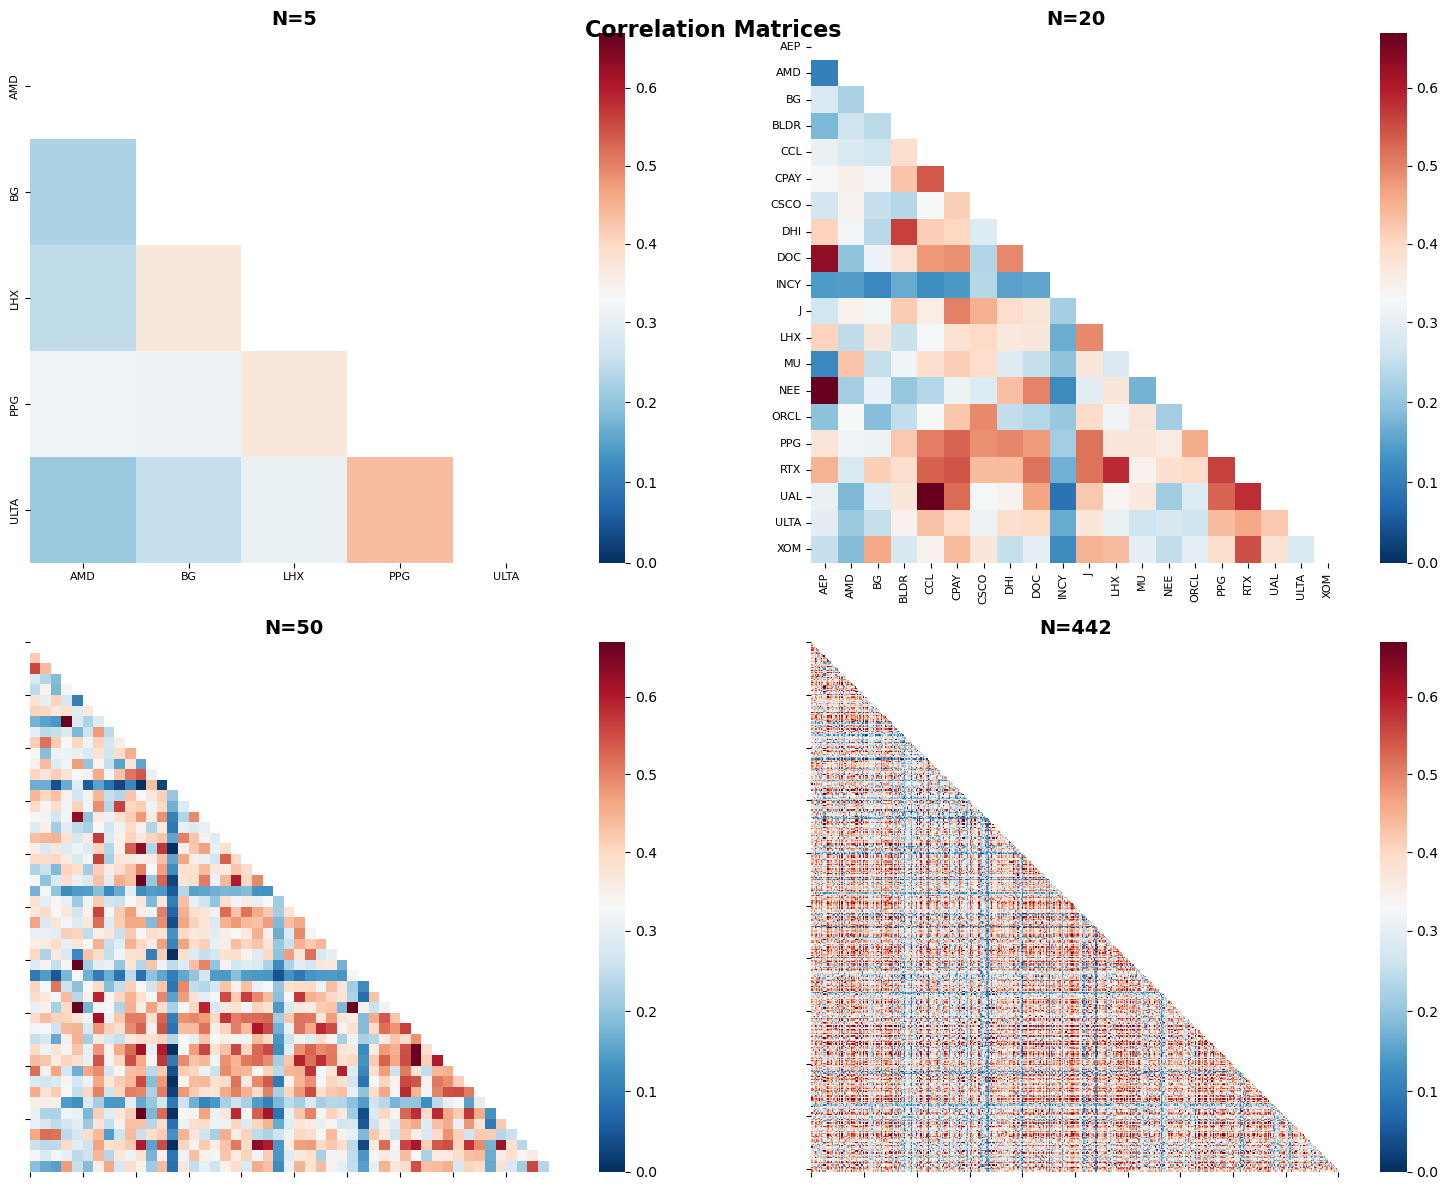

In [ ]:
# 2x2 Correlation Heatmaps for Various Subsets
from matplotlib.colors import TwoSlopeNorm

# Define subsets to analyze - smallest 3 N values and largest N
N_values_sorted = sorted([5, 20, 50, 100, len(rets_raw.columns)])
subset_configs = [
    {'name': f'N={N_values_sorted[0]}', 'size': N_values_sorted[0], 'title': f'N={N_values_sorted[0]}'},
    {'name': f'N={N_values_sorted[1]}', 'size': N_values_sorted[1], 'title': f'N={N_values_sorted[1]}'},
    {'name': f'N={N_values_sorted[2]}', 'size': N_values_sorted[2], 'title': f'N={N_values_sorted[2]}'},
    {'name': f'N={N_values_sorted[-1]}', 'size': N_values_sorted[-1], 'title': f'N={N_values_sorted[-1]}'}
]

# Use the same random seed for consistency
np.random.seed(2025)
all_assets = list(rets_raw.columns)
np.random.shuffle(all_assets)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, config in enumerate(subset_configs):
    # Select assets for this subset
    selected_assets = sorted(all_assets[:config['size']])
    rets_subset = rets_raw[selected_assets]
    
    # Calculate correlation matrix
    corr_matrix = rets_subset.corr()
    
    # Set upper triangle and diagonal to NaN for cleaner visualization
    mask = np.triu(np.ones_like(corr_matrix), k=0)
    corr_matrix_masked = corr_matrix.copy()
    corr_matrix_masked[mask.astype(bool)] = np.nan
    
    # Set up color normalization
    center = 0.33
    vmin = 0
    vmax = 0.67
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
    
    # Create heatmap
    sns.heatmap(corr_matrix_masked, 
                annot=False,  # No annotations
                norm=norm, 
                cmap='RdBu_r', 
                cbar=True,
                ax=axes[i],
                square=True)
    
    axes[i].set_title(config['title'], fontsize=14, fontweight='bold')
    
    # Adjust tick labels for readability
    if config['size'] <= 20:
        axes[i].tick_params(axis='both', labelsize=8)
    else:
        axes[i].tick_params(axis='both', labelsize=6)
        # For larger matrices, show fewer tick labels
        step = max(1, config['size'] // 10)
        axes[i].set_xticks(range(0, config['size'], step))
        axes[i].set_yticks(range(0, config['size'], step))

plt.tight_layout()
plt.suptitle('Correlation Matrices', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()


In [ ]:
# Correlation Statistics DataFrame
correlation_stats = []

# Use the same random seed for consistency
np.random.seed(2025)
all_assets = list(rets_raw.columns)
np.random.shuffle(all_assets)

for config in subset_configs:
    # Select assets for this subset
    selected_assets = sorted(all_assets[:config['size']])
    rets_subset = rets_raw[selected_assets]
    
    # Calculate correlation matrix
    corr_matrix = rets_subset.corr()
    
    # Calculate correlation statistics (excluding diagonal)
    mask = np.triu(np.ones_like(corr_matrix), k=1)
    correlations = corr_matrix.values[mask.astype(bool)]
    avg_pairwise_corr = correlations.mean()
    min_corr = correlations.min()
    max_corr = correlations.max()
    
    # Calculate condition number and determinant of correlation matrix
    condition_number = np.linalg.cond(corr_matrix)
    determinant = np.linalg.det(corr_matrix)
    
    correlation_stats.append({
        'N': config['size'],
        'Min Correlation': min_corr,
        'Max Correlation': max_corr,
        'Avg Pairwise Correlation': avg_pairwise_corr,
        'Condition Number': condition_number,
        'Determinant': determinant
    })

# Create DataFrame
correlation_df = pd.DataFrame(correlation_stats)
correlation_df = correlation_df.set_index('N')
# Format the display
display_df = correlation_df.copy()
display_df['Min Correlation'] = display_df['Min Correlation'].apply(lambda x: f"{x:.0%}")
display_df['Max Correlation'] = display_df['Max Correlation'].apply(lambda x: f"{x:.0%}")
display_df['Avg Pairwise Correlation'] = display_df['Avg Pairwise Correlation'].apply(lambda x: f"{x:.0%}")
display_df['Condition Number'] = display_df['Condition Number'].apply(lambda x: f"{x:,.0f}")
display_df['Determinant'] = display_df['Determinant'].apply(lambda x: f"{x:.0e}")

display_df


Min Correlation Max Correlation Avg Pairwise Correlation Condition Number  \
N                                                                               
5               21%             43%                      30%                4   
20               9%             72%                      34%               33   
50              -5%             77%                      34%              115   
442             -9%             94%                      36%           83,061   

    Determinant  
N                
5         5e-01  
20        1e-04  
50        1e-13  
442       0e+00

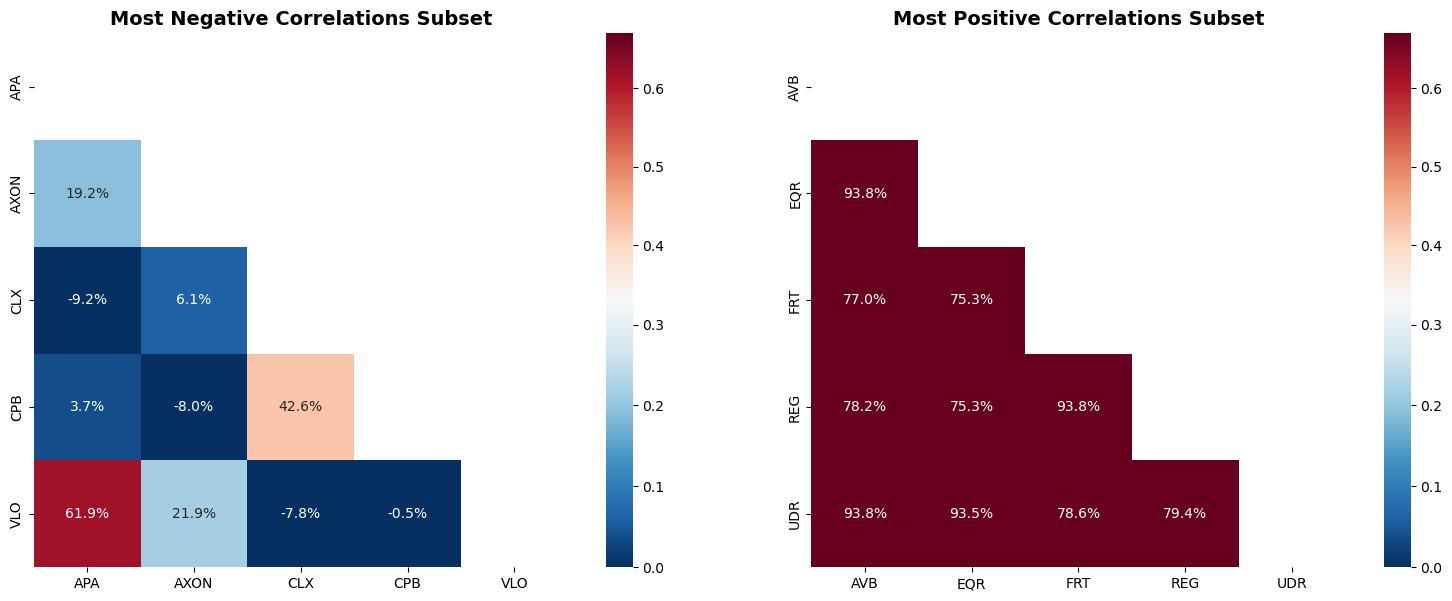

In [ ]:
# Correlation Heatmaps for Most Negative and Most Positive Pairs
from matplotlib.colors import TwoSlopeNorm

# Calculate correlation matrix for full dataset
full_corr_matrix = rets_raw.corr()

# Find all pairwise correlations (excluding diagonal)
mask = np.triu(np.ones_like(full_corr_matrix), k=1)
correlations_flat = full_corr_matrix.values[mask.astype(bool)]

# Get indices of the correlations
row_indices, col_indices = np.where(mask)

# Find the 6 stocks involved in the 3 most negative correlations
min_corr_indices = []
min_corr_values = []
correlations_temp = correlations_flat.copy()
for i in range(3):
    min_idx = np.argmin(correlations_temp)
    min_corr_indices.append((row_indices[min_idx], col_indices[min_idx]))
    min_corr_values.append(correlations_temp[min_idx])
    correlations_temp[min_idx] = 0  # Remove this correlation from consideration

# Get unique stocks from the 3 most negative pairs
min_corr_stocks = set()
for row_idx, col_idx in min_corr_indices:
    min_corr_stocks.add(full_corr_matrix.index[row_idx])
    min_corr_stocks.add(full_corr_matrix.index[col_idx])
min_corr_stocks = sorted(list(min_corr_stocks))

# Find the 6 stocks involved in the 3 most positive correlations
max_corr_indices = []
max_corr_values = []
correlations_temp = correlations_flat.copy()
for i in range(3):
    max_idx = np.argmax(correlations_temp)
    max_corr_indices.append((row_indices[max_idx], col_indices[max_idx]))
    max_corr_values.append(correlations_temp[max_idx])
    correlations_temp[max_idx] = 0  # Remove this correlation from consideration

# Get unique stocks from the 3 most positive pairs
max_corr_stocks = set()
for row_idx, col_idx in max_corr_indices:
    max_corr_stocks.add(full_corr_matrix.index[row_idx])
    max_corr_stocks.add(full_corr_matrix.index[col_idx])
max_corr_stocks = sorted(list(max_corr_stocks))

# Create 1x2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Set up color normalization
center = 0.33
vmin = 0
vmax = 0.67
norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

# Plot 1: Most negative correlations subset
min_corr_subset = full_corr_matrix.loc[min_corr_stocks, min_corr_stocks]
# Set upper triangle and diagonal to NaN
mask_min = np.triu(np.ones_like(min_corr_subset), k=0)
min_corr_subset_masked = min_corr_subset.copy()
min_corr_subset_masked[mask_min.astype(bool)] = np.nan

sns.heatmap(min_corr_subset_masked, 
            annot=True, 
            fmt='.1%', 
            norm=norm, 
            cmap='RdBu_r', 
            cbar=True,
            ax=axes[0],
            square=True)
axes[0].set_title('Most Negative Correlations Subset', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Plot 2: Most positive correlations subset
max_corr_subset = full_corr_matrix.loc[max_corr_stocks, max_corr_stocks]
# Set upper triangle and diagonal to NaN
mask_max = np.triu(np.ones_like(max_corr_subset), k=0)
max_corr_subset_masked = max_corr_subset.copy()
max_corr_subset_masked[mask_max.astype(bool)] = np.nan

sns.heatmap(max_corr_subset_masked, 
            annot=True, 
            fmt='.1%', 
            norm=norm, 
            cmap='RdBu_r', 
            cbar=True,
            ax=axes[1],
            square=True)
axes[1].set_title('Most Positive Correlations Subset', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
# Get firm names for the most and least correlated pairs
# Read the first sheet to get ticker to company name mapping
ticker_mapping = pd.read_excel(filepath_data, sheet_name=0)

# Create a dictionary mapping tickers to company names
ticker_to_name = dict(zip(ticker_mapping.iloc[:, 0], ticker_mapping.iloc[:, 1]))

# Create DataFrame for 3 most negative correlations
most_negative_pairs = []
for i, (row_idx, col_idx) in enumerate(min_corr_indices):
    stock1 = full_corr_matrix.index[row_idx]
    stock2 = full_corr_matrix.index[col_idx]
    corr_val = min_corr_values[i]
    
    most_negative_pairs.append({
        'Ticker_1': stock1,
        'Company_1': ticker_to_name.get(stock1, 'Unknown'),
        'Ticker_2': stock2,
        'Company_2': ticker_to_name.get(stock2, 'Unknown'),
        'Correlation': corr_val
    })

most_negative_df = pd.DataFrame(most_negative_pairs)
most_negative_df.index = [f'Pair {i+1}' for i in range(len(most_negative_pairs))]

# Create DataFrame for 3 most positive correlations
most_positive_pairs = []
for i, (row_idx, col_idx) in enumerate(max_corr_indices):
    stock1 = full_corr_matrix.index[row_idx]
    stock2 = full_corr_matrix.index[col_idx]
    corr_val = max_corr_values[i]
    
    most_positive_pairs.append({
        'Ticker_1': stock1,
        'Company_1': ticker_to_name.get(stock1, 'Unknown'),
        'Ticker_2': stock2,
        'Company_2': ticker_to_name.get(stock2, 'Unknown'),
        'Correlation': corr_val
    })

most_positive_df = pd.DataFrame(most_positive_pairs)
most_positive_df.index = [f'Pair {i+1}' for i in range(len(most_positive_pairs))]

# Display the DataFrames
most_negative_df[['Ticker_1', 'Company_1', 'Ticker_2', 'Company_2', 'Correlation']].style.hide(axis='index').format({'Correlation': '{:.0%}'})


In [ ]:
most_positive_df[['Ticker_1', 'Company_1', 'Ticker_2', 'Company_2', 'Correlation']].style.hide(axis='index').format({'Correlation': '{:.0%}'})
